In [537]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from statsmodels.formula.api import ols
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt  # To visualize
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

In [538]:
# Declaring global variables
RQUARE_CUTOFF = 0.7 # Min R-square value set to 75%
SIGMA = 2  # Number of standard deviation. 2-sigma

In [539]:
# exponential smoothing function
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1-alpha) * result[n-1])
    return result

In [540]:
# Plot exponential smoothing
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [541]:
# function that locates and remove outliers using interquartile range
def drop_outlier(data, variable):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data[variable]), [25, 75])
 
    # compute IQR
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.50 * iqr)
    upper_bound = q3 + (1.50 * iqr)
    
    # dropping outliers
    no_outliers = data.drop(data[(data[variable] <= lower_bound) | (data[variable] >= upper_bound)].index)
    #no_outliers = data.drop(data[data[variable] <= lower_bound], inplace=True)
    return no_outliers

In [542]:
# function that locates and remove outliers using standard deviation
def std_outliers(data, variable):
    mean = data[variable].mean()
    #residual = data[variable] - avg
    #std = residual.std()
    std = data[variable].std()
    #outliers = (np.abs(residual) > std * sigma)
    no_outliers = data.drop(data[(np.abs(data[variable] - mean) > std * SIGMA)].index)
    return no_outliers

In [543]:
# Function that takes a directory pathname and returns the list of csv files in that directory
def get_csvfiles(pathname):
    dir_path = Path(pathname)
    csvfile = []
    p = dir_path.glob('*.csv')
    files = [x for x in p if x.is_file()]
    for f in files:
        for part in f.parts:
            if not part.startswith('.') and part.endswith('.csv'):
                csvfile.append(part)
    return csvfile

In [544]:
# This function takes the absolute or relative pathname to the data directory,
# Then create and return a list of dataframes
def get_dataframes(dir_pathname):
    dataframes = []
    csv_filenames = get_csvfiles(dir_pathname)
    for file in csv_filenames:
        table_name = file.split('.')[0]
        df = pd.read_csv(Path(dir_pathname + file), header=1, usecols = ['TIMESTAMP', 'AirTemp_Avg', 'Irradiance_Pyr_NOCT_Avg', 'Wind_speed', 'Wind_direction', 'NOCT_Mod1_Cent1_Avg', 'NOCT_Mod1_Cent2_Avg'])
        #df = pd.read_csv(Path(dir_pathname + file))
        dataframes.append(df)
    return dataframes

In [545]:
# This function removes outliers that lie more than n_std standard deviations away from the mean
# It takes the dataframe (df), the list of columns (columns), and the number of standard deviations (n_std)
def remove_outliers(df,columns,n_std):
    for col in columns:        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [546]:
# This function takes a dataframe and split into a list of dataframes to obtain daily data

def split_df(df):
    df_lst = []  # declare the list to return
    df['date'] = df['date'].astype(str)  # convert date column to string
    dates = df['date'].unique().tolist() # store unique dates into a list
    for Date in dates:
        df_lst.append(df.loc[df['date'].str.contains(Date)])   # create and append df of rows that contain the date string
        
    return df_lst

In [547]:
# Determine multicollinearity among independent variables by computing VIF
# VIFs between 1 and 5 suggest that there is a moderate correlation, 
# but it is not severe enough to warrant corrective measures. 
# VIFs greater than 5 represent critical levels of multicollinearity where the coefficients are poorly estimated, 
# and the p-values are questionable.

# the independent variables set
#X = noct_csv[['AirTemp_Avg', 'Wind_speed', 'Irradiance_Pyr_NOCT_Avg']]

# The parameters are the dataframe and the sliced dataframe of X-columns
def get_VIF(df, X_df):
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df.columns  # sliced dataframe of X-columns passed as parameter
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i)
                          for i in range(len(X_df.columns))]
  
    return vif_data

In [548]:
# Regression Model summary with ANOVA

def get_anova(df, X, Y):
    #X = noct_csv[['AirTemp_Avg', 'Wind_speed','Irradiance_Pyr_NOCT_Avg']]
    # X = noct_csv[['Wind_speed','Irradiance_Pyr_NOCT_Avg']]
    #Y = noct_csv['T_RISE'] = noct_csv.loc[:, ['NOCT_Mod2_Cent1_Avg','NOCT_Mod2_Cent2_Avg']].mean(axis=1) - noct_csv['AirTemp_Avg']

    model = ols("Y ~ X", noct_csv).fit()

    # Print the summary
    #print(model.summary())

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    #print('\nANOVA results')
    return anova_results

In [549]:
directory_pathname = "Data/Control_Module/"
dataframes = get_dataframes(directory_pathname)
combined_data = pd.concat(dataframes, axis=0, join='inner')
combined_data

C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (2,3,4,6,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  


,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,TS,NaN,NaN,Deg,NaN,Deg C,Deg C
1,NaN,Avg,WVc,WVc,Avg,Avg,Avg
2,4/10/2022 7:18,20.6,1.33,99.99999,180.2989,NAN,NAN
3,4/10/2022 7:18,20.6,1.11,111,180.2989,NAN,NAN
4,4/10/2022 7:18,20.6,1.09,116,180.2989,NAN,NAN
...,...,...,...,...,...,...,...
173262,4/11/2023 1:15,21.9,0.22,197.0,0.0,17.16,17.15
173263,4/11/2023 1:15,21.9,0.17,198.0,0.0,17.17,17.15
173264,4/11/2023 1:15,21.8,0.16,191.0,0.0,17.17,17.14
173265,4/11/2023 1:15,21.8,0.19,187.0,0.0,17.16,17.11


In [550]:
# Drop rows.
# Could also use labels: noct_csv.drop(labels=[0,1], axis=0)
combined_data.drop(combined_data.index[[0,1]], axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
2,4/10/2022 7:18,20.6,1.33,99.99999,180.2989,NAN,NAN
3,4/10/2022 7:18,20.6,1.11,111,180.2989,NAN,NAN
4,4/10/2022 7:18,20.6,1.09,116,180.2989,NAN,NAN
5,4/10/2022 7:18,20.6,1.22,130,181.2841,NAN,NAN
6,4/10/2022 7:18,20.6,0.6,126,181.2841,NAN,NAN
...,...,...,...,...,...,...,...
173262,4/11/2023 1:15,21.9,0.22,197.0,0.0,17.16,17.15
173263,4/11/2023 1:15,21.9,0.17,198.0,0.0,17.17,17.15
173264,4/11/2023 1:15,21.8,0.16,191.0,0.0,17.17,17.14
173265,4/11/2023 1:15,21.8,0.19,187.0,0.0,17.16,17.11


In [551]:
# Change "NAN" values to NaN so they can be dropped
combined_data.replace("NAN", np.NaN, inplace=True)

In [552]:
# Drop the previous index and reset 
combined_data.reset_index(drop=True, inplace=True)
combined_data.head()

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,4/10/2022 7:18,20.6,1.33,99.99999,180.2989,NaN,NaN
1,4/10/2022 7:18,20.6,1.11,111,180.2989,NaN,NaN
2,4/10/2022 7:18,20.6,1.09,116,180.2989,NaN,NaN
3,4/10/2022 7:18,20.6,1.22,130,181.2841,NaN,NaN
4,4/10/2022 7:18,20.6,0.6,126,181.2841,NaN,NaN


In [553]:
# Check data types
combined_data.dtypes

TIMESTAMP                  object
AirTemp_Avg                object
Wind_speed                 object
Wind_direction             object
Irradiance_Pyr_NOCT_Avg    object
NOCT_Mod1_Cent1_Avg        object
NOCT_Mod1_Cent2_Avg        object
dtype: object

In [554]:
# Convert numeric columns to float
data = ['AirTemp_Avg', 'Irradiance_Pyr_NOCT_Avg', 'Wind_speed', 'Wind_direction', 'NOCT_Mod1_Cent1_Avg', 'NOCT_Mod1_Cent2_Avg']
for col in data:
    combined_data[col] = combined_data[col].astype('float')
combined_data.dtypes

TIMESTAMP                   object
AirTemp_Avg                float64
Wind_speed                 float64
Wind_direction             float64
Irradiance_Pyr_NOCT_Avg    float64
NOCT_Mod1_Cent1_Avg        float64
NOCT_Mod1_Cent2_Avg        float64
dtype: object

In [555]:
# Delete all data outside the range 0.25 < wind speed < 1.75
indexWS = combined_data[ (combined_data['Wind_speed']<0.25) | (combined_data['Wind_speed']>1.75) ].index  # get index of the desired rows to drop
combined_data.drop(indexWS, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,4/10/2022 7:18,20.6,1.33,99.99999,180.2989,NaN,NaN
1,4/10/2022 7:18,20.6,1.11,111.00000,180.2989,NaN,NaN
2,4/10/2022 7:18,20.6,1.09,116.00000,180.2989,NaN,NaN
3,4/10/2022 7:18,20.6,1.22,130.00000,181.2841,NaN,NaN
4,4/10/2022 7:18,20.6,0.60,126.00000,181.2841,NaN,NaN
...,...,...,...,...,...,...,...
4080322,4/11/2023 1:14,21.9,0.33,245.00000,0.0000,17.34,17.30
4080323,4/11/2023 1:14,21.9,0.35,251.00000,0.0000,17.33,17.29
4080324,4/11/2023 1:14,21.9,0.34,251.00000,0.0000,17.32,17.31
4080325,4/11/2023 1:14,21.9,0.28,248.00000,0.0000,17.30,17.29


In [556]:
# Delete all Wind Direction data within 290 - 250, and 69 - 110
indexWD = combined_data[ ((combined_data['Wind_direction']>250) & (combined_data['Wind_direction']<=290)) | ((combined_data['Wind_direction']>69.99) & (combined_data['Wind_direction']<=110)) ].index  
combined_data.drop(indexWD, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
1,4/10/2022 7:18,20.6,1.11,111.0,180.2989,NaN,NaN
2,4/10/2022 7:18,20.6,1.09,116.0,180.2989,NaN,NaN
3,4/10/2022 7:18,20.6,1.22,130.0,181.2841,NaN,NaN
4,4/10/2022 7:18,20.6,0.60,126.0,181.2841,NaN,NaN
7,4/10/2022 7:19,20.6,1.15,111.0,182.2693,NaN,NaN
...,...,...,...,...,...,...,...
4080315,4/11/2023 1:13,22.0,0.38,249.0,0.0000,17.38,17.35
4080321,4/11/2023 1:14,21.9,0.40,248.0,0.0000,17.32,17.29
4080322,4/11/2023 1:14,21.9,0.33,245.0,0.0000,17.34,17.30
4080325,4/11/2023 1:14,21.9,0.28,248.0,0.0000,17.30,17.29


In [557]:
# Delete all Irradiance data below 400 and above 1100
indexIrr = combined_data[ (combined_data['Irradiance_Pyr_NOCT_Avg']<400) | (combined_data['Irradiance_Pyr_NOCT_Avg']>1100) ].index
combined_data.drop(indexIrr, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
651,4/10/2022 8:12,23.1,1.52,154.0,400.2790,NaN,NaN
652,4/10/2022 8:12,23.1,1.10,133.0,400.7714,NaN,NaN
653,4/10/2022 8:12,23.1,0.81,119.0,400.7714,NaN,NaN
655,4/10/2022 8:13,23.1,1.28,147.0,401.7561,NaN,NaN
656,4/10/2022 8:13,23.1,1.07,157.0,401.7561,NaN,NaN
...,...,...,...,...,...,...,...
4074193,4/10/2023 16:42,37.3,1.61,169.0,401.7508,48.89,49.43
4074194,4/10/2023 16:42,37.3,1.21,207.0,401.2567,48.93,49.51
4074195,4/10/2023 16:43,37.3,1.11,172.0,401.2567,49.07,49.60
4074197,4/10/2023 16:43,37.3,0.69,188.0,400.7625,49.26,49.71


In [558]:
# Create the T-rise and module_temperature columns
combined_data['module_temperature'] = combined_data[['NOCT_Mod1_Cent1_Avg','NOCT_Mod1_Cent2_Avg']].mean(axis=1)
combined_data['T_RISE'] = combined_data[['NOCT_Mod1_Cent1_Avg','NOCT_Mod1_Cent2_Avg']].mean(axis=1) - combined_data['AirTemp_Avg']
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE
651,4/10/2022 8:12,23.1,1.52,154.0,400.2790,NaN,NaN,NaN,NaN
652,4/10/2022 8:12,23.1,1.10,133.0,400.7714,NaN,NaN,NaN,NaN
653,4/10/2022 8:12,23.1,0.81,119.0,400.7714,NaN,NaN,NaN,NaN
655,4/10/2022 8:13,23.1,1.28,147.0,401.7561,NaN,NaN,NaN,NaN
656,4/10/2022 8:13,23.1,1.07,157.0,401.7561,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4074193,4/10/2023 16:42,37.3,1.61,169.0,401.7508,48.89,49.43,49.160,11.860
4074194,4/10/2023 16:42,37.3,1.21,207.0,401.2567,48.93,49.51,49.220,11.920
4074195,4/10/2023 16:43,37.3,1.11,172.0,401.2567,49.07,49.60,49.335,12.035
4074197,4/10/2023 16:43,37.3,0.69,188.0,400.7625,49.26,49.71,49.485,12.185


In [559]:
combined_data["Date"] = pd.to_datetime(combined_data["TIMESTAMP"])
display(combined_data.dtypes)
display(combined_data.head(5))

TIMESTAMP                          object
AirTemp_Avg                       float64
Wind_speed                        float64
Wind_direction                    float64
Irradiance_Pyr_NOCT_Avg           float64
NOCT_Mod1_Cent1_Avg               float64
NOCT_Mod1_Cent2_Avg               float64
module_temperature                float64
T_RISE                            float64
Date                       datetime64[ns]
dtype: object

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date
651,4/10/2022 8:12,23.1,1.52,154.0,400.2790,NaN,NaN,NaN,NaN,2022-04-10 08:12:00
652,4/10/2022 8:12,23.1,1.10,133.0,400.7714,NaN,NaN,NaN,NaN,2022-04-10 08:12:00
653,4/10/2022 8:12,23.1,0.81,119.0,400.7714,NaN,NaN,NaN,NaN,2022-04-10 08:12:00
655,4/10/2022 8:13,23.1,1.28,147.0,401.7561,NaN,NaN,NaN,NaN,2022-04-10 08:13:00
656,4/10/2022 8:13,23.1,1.07,157.0,401.7561,NaN,NaN,NaN,NaN,2022-04-10 08:13:00


In [560]:
combined_data["date"] = combined_data["Date"].dt.date
combined_data["year"] = combined_data["Date"].dt.year
combined_data["month"] = combined_data["Date"].dt.month
combined_data["day"] = combined_data["Date"].dt.day
combined_data["hour"] = combined_data["Date"].dt.hour
combined_data["minute"] = combined_data["Date"].dt.minute
#noct_csv.drop("TIMESTAMP", axis=1, inplace=True)
combined_data.head(5)

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
651,4/10/2022 8:12,23.1,1.52,154.0,400.2790,NaN,NaN,NaN,NaN,2022-04-10 08:12:00,2022-04-10,2022.0,4.0,10.0,8.0,12.0
652,4/10/2022 8:12,23.1,1.10,133.0,400.7714,NaN,NaN,NaN,NaN,2022-04-10 08:12:00,2022-04-10,2022.0,4.0,10.0,8.0,12.0
653,4/10/2022 8:12,23.1,0.81,119.0,400.7714,NaN,NaN,NaN,NaN,2022-04-10 08:12:00,2022-04-10,2022.0,4.0,10.0,8.0,12.0
655,4/10/2022 8:13,23.1,1.28,147.0,401.7561,NaN,NaN,NaN,NaN,2022-04-10 08:13:00,2022-04-10,2022.0,4.0,10.0,8.0,13.0
656,4/10/2022 8:13,23.1,1.07,157.0,401.7561,NaN,NaN,NaN,NaN,2022-04-10 08:13:00,2022-04-10,2022.0,4.0,10.0,8.0,13.0


In [561]:
combined_data.dropna(axis=0, how='any', inplace=True)
combined_data.sort_values(by=['Date'])
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
194512,4/25/2022 11:27,30.3,1.48,336.0,964.9658,47.10,46.15,46.625,16.325,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194514,4/25/2022 11:27,30.3,1.48,18.0,964.9658,47.81,46.90,47.355,17.055,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194517,4/25/2022 11:27,30.4,1.00,13.0,962.9938,48.82,47.76,48.290,17.890,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194525,4/25/2022 11:28,30.4,1.71,32.0,961.0275,50.72,49.66,50.190,19.790,2022-04-25 11:28:00,2022-04-25,2022.0,4.0,25.0,11.0,28.0
194527,4/25/2022 11:28,30.4,1.60,357.0,962.9938,51.45,50.06,50.755,20.355,2022-04-25 11:28:00,2022-04-25,2022.0,4.0,25.0,11.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074193,4/10/2023 16:42,37.3,1.61,169.0,401.7508,48.89,49.43,49.160,11.860,2023-04-10 16:42:00,2023-04-10,2023.0,4.0,10.0,16.0,42.0
4074194,4/10/2023 16:42,37.3,1.21,207.0,401.2567,48.93,49.51,49.220,11.920,2023-04-10 16:42:00,2023-04-10,2023.0,4.0,10.0,16.0,42.0
4074195,4/10/2023 16:43,37.3,1.11,172.0,401.2567,49.07,49.60,49.335,12.035,2023-04-10 16:43:00,2023-04-10,2023.0,4.0,10.0,16.0,43.0
4074197,4/10/2023 16:43,37.3,0.69,188.0,400.7625,49.26,49.71,49.485,12.185,2023-04-10 16:43:00,2023-04-10,2023.0,4.0,10.0,16.0,43.0


In [562]:
# Slice data between 11am and 1pm
indexHour = combined_data[ ((combined_data['hour']<11) | (combined_data['hour']>13))].index
combined_data.drop(indexHour, axis=0, inplace=True)

In [563]:
# Split the data into a list of daily data
noct_dataframes = split_df(combined_data)
noct_dataframes[0]

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
194512,4/25/2022 11:27,30.3,1.48,336.00000,964.9658,47.10,46.15,46.625,16.325,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194514,4/25/2022 11:27,30.3,1.48,18.00000,964.9658,47.81,46.90,47.355,17.055,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194517,4/25/2022 11:27,30.4,1.00,13.00000,962.9938,48.82,47.76,48.290,17.890,2022-04-25 11:27:00,2022-04-25,2022.0,4.0,25.0,11.0,27.0
194525,4/25/2022 11:28,30.4,1.71,32.00000,961.0275,50.72,49.66,50.190,19.790,2022-04-25 11:28:00,2022-04-25,2022.0,4.0,25.0,11.0,28.0
194527,4/25/2022 11:28,30.4,1.60,357.00000,962.9938,51.45,50.06,50.755,20.355,2022-04-25 11:28:00,2022-04-25,2022.0,4.0,25.0,11.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196340,4/25/2022 13:59,33.6,0.90,36.99999,860.2892,74.51,77.25,75.880,42.280,2022-04-25 13:59:00,2022-04-25,2022.0,4.0,25.0,13.0,59.0
196341,4/25/2022 13:59,33.6,1.32,56.00000,859.7980,74.55,77.27,75.910,42.310,2022-04-25 13:59:00,2022-04-25,2022.0,4.0,25.0,13.0,59.0
196343,4/25/2022 13:59,33.6,0.32,115.00000,859.3066,74.79,77.34,76.065,42.465,2022-04-25 13:59:00,2022-04-25,2022.0,4.0,25.0,13.0,59.0
196344,4/25/2022 13:59,33.6,0.30,64.00000,858.3240,75.46,77.43,76.445,42.845,2022-04-25 13:59:00,2022-04-25,2022.0,4.0,25.0,13.0,59.0


In [564]:
# Aggregate data by minutes
daily_noct = []
for dataframe in noct_dataframes:
    noct_df = dataframe[["date", "hour","minute", "month", "AirTemp_Avg", "Wind_speed", "Wind_direction", "Irradiance_Pyr_NOCT_Avg", "module_temperature", "T_RISE"]]
    noct_df_agg = noct_df.groupby(["date", "hour", "minute"]).mean()
    noct_df_agg.reset_index(inplace=True)
    daily_noct.append(noct_df_agg)

daily_noct[0]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2022-04-25,11.0,27.0,4.0,30.333333,1.320000,122.333333,964.308467,47.423333,17.090000
1,2022-04-25,11.0,28.0,4.0,30.400000,1.112000,166.199998,962.502220,51.048000,20.648000
2,2022-04-25,11.0,29.0,4.0,30.400000,1.035000,34.000000,965.446800,54.310000,23.910000
3,2022-04-25,11.0,30.0,4.0,30.337500,1.133750,71.374999,964.955263,56.561875,26.224375
4,2022-04-25,11.0,31.0,4.0,30.250000,1.143333,105.166667,964.790267,58.401667,28.151667
...,...,...,...,...,...,...,...,...,...,...
140,2022-04-25,13.0,55.0,4.0,33.577778,0.816667,153.888889,868.976544,76.574444,42.996667
141,2022-04-25,13.0,56.0,4.0,33.663636,0.928182,188.727273,866.862718,76.501364,42.837727
142,2022-04-25,13.0,57.0,4.0,33.700000,0.701000,192.900000,864.611730,76.956500,43.256500
143,2022-04-25,13.0,58.0,4.0,33.700000,1.374444,71.999999,861.157867,76.417222,42.717222


In [565]:
len(daily_noct)

217

In [566]:
# Cleaning ambient temperatures
# If min amb temp around 35, delete data where (max - min) amb temp are above 5 degC
# Otherwise, Delete all Ambient Temperature data below 5 degC and above 35 degC if max Tamb < 35
for noct in daily_noct:
    indexShift = noct[ (noct['AirTemp_Avg'] - noct['AirTemp_Avg'].shift(1)) < 0 ].index
    noct.drop(indexShift, axis=0, inplace=True)
    if noct['AirTemp_Avg'].min() >= 35:
        while (noct['AirTemp_Avg'].max() - noct['AirTemp_Avg'].min()) > 5:
            noct.drop(noct[(noct['AirTemp_Avg'] == noct['AirTemp_Avg'].max()) | (noct["AirTemp_Avg"] == noct['AirTemp_Avg'].min())].index, axis=0, inplace=True)
    else:
        indexTamb = noct[ ((noct['AirTemp_Avg']<5) & (noct['AirTemp_Avg']>35))].index
        noct.drop(indexTamb, axis=0, inplace=True)
    #print(f"{noct.index[0][0]}: \n{noct}")

In [567]:
# Indice 5 is known to have only afternoon data. This should be removed
daily_noct[5]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2022-05-28,13.0,4.0,5.0,36.800000,1.510000,183.000000,909.629200,67.790000,30.990000
1,2022-05-28,13.0,5.0,5.0,36.900000,1.203750,151.000000,905.740338,67.646250,30.746250
2,2022-05-28,13.0,8.0,5.0,37.400000,1.530000,230.500000,853.339050,64.885000,27.485000
5,2022-05-28,13.0,12.0,5.0,37.000000,1.570000,132.000000,857.764300,63.752500,26.752500
7,2022-05-28,13.0,14.0,5.0,37.000000,1.265714,209.571429,940.994371,64.135000,27.135000
10,2022-05-28,13.0,17.0,5.0,36.800000,1.100000,196.666667,927.645633,64.864444,28.064444
14,2022-05-28,13.0,21.0,5.0,36.600000,1.416667,235.333333,912.057267,65.886667,29.286667
15,2022-05-28,13.0,22.0,5.0,36.766667,1.116667,210.833333,915.924550,66.210000,29.443333
16,2022-05-28,13.0,23.0,5.0,36.837500,1.195000,193.000000,916.993575,66.235000,29.397500
17,2022-05-28,13.0,24.0,5.0,36.900000,1.550000,228.000000,912.549300,66.975000,30.075000


In [568]:
# We want to delete all the data which do not have points before and after noon
to_remove = []   # This will hold the indices of the dataframe list to be removed
for i, noct in enumerate(daily_noct):
    am = False
    pm = False
    if noct['hour'].min() == 11:
        am = True
    if noct['hour'].max() in [12,13]:
        pm = True
    if (am == False or pm == False):
        to_remove.append(i)
# Sort the indice of dataframes to drop
# By starting from higher to lower indices, we're guaranteed that the indices on the dataframe will remain unmodified while deleting
for x in sorted(to_remove, reverse=True):
    del daily_noct[x]

In [569]:
# Checking that the previous indice 5 was effectively deleted.
daily_noct[5]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2022-05-29,11.0,0.0,5.0,31.260000,1.298000,309.000000,858.525660,62.108000,30.848000
1,2022-05-29,11.0,1.0,5.0,31.300000,0.850000,296.000000,860.797300,62.190000,30.890000
6,2022-05-29,11.0,6.0,5.0,30.157143,1.278571,69.142857,867.216843,62.760000,32.602857
7,2022-05-29,11.0,7.0,5.0,30.275000,0.620000,161.750000,868.756588,62.426250,32.151250
8,2022-05-29,11.0,8.0,5.0,30.344444,0.931111,193.666667,868.858222,61.322778,30.978333
...,...,...,...,...,...,...,...,...,...,...
133,2022-05-29,13.0,43.0,5.0,33.300000,0.920000,317.000000,838.569100,58.330000,25.030000
134,2022-05-29,13.0,44.0,5.0,33.300000,1.316667,316.000000,838.247367,57.868333,24.568333
138,2022-05-29,13.0,49.0,5.0,33.400000,1.296000,326.200000,827.607380,57.531000,24.131000
141,2022-05-29,13.0,52.0,5.0,33.400000,1.240000,281.500000,829.431850,57.292500,23.892500


In [570]:
'''
for noct in daily_noct:
    noct.set_index(['date'], inplace=True)
'''

"\nfor noct in daily_noct:\n    noct.set_index(['date'], inplace=True)\n"

In [571]:
#daily_noct[1].index[0]

In [572]:
'''
for noct in daily_noct:
    noct.set_index(['date','hour','minute'], inplace=True)
daily_noct[0].index
'''

"\nfor noct in daily_noct:\n    noct.set_index(['date','hour','minute'], inplace=True)\ndaily_noct[0].index\n"

In [573]:
# Combining the list of dataframes into a single one
combined_daily_noct = pd.concat(daily_noct, axis=0, join='inner')
combined_daily_noct

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2022-04-25,11.0,27.0,4.0,30.333333,1.320000,122.333333,964.308467,47.423333,17.090000
1,2022-04-25,11.0,28.0,4.0,30.400000,1.112000,166.199998,962.502220,51.048000,20.648000
2,2022-04-25,11.0,29.0,4.0,30.400000,1.035000,34.000000,965.446800,54.310000,23.910000
8,2022-04-25,11.0,35.0,4.0,30.175000,0.652500,182.625000,980.002525,64.187500,34.012500
9,2022-04-25,11.0,36.0,4.0,30.200000,0.827500,217.375000,978.896200,65.266250,35.066250
...,...,...,...,...,...,...,...,...,...,...
156,2023-04-10,13.0,45.0,4.0,36.500000,1.144000,137.800000,988.073080,63.852000,27.352000
161,2023-04-10,13.0,50.0,4.0,36.200000,1.410000,168.500000,976.911850,64.205000,28.005000
165,2023-04-10,13.0,57.0,4.0,35.100000,0.668000,207.799998,951.642360,66.321000,31.221000
166,2023-04-10,13.0,58.0,4.0,35.133333,1.198333,106.000000,949.441067,66.216667,31.083333


In [574]:
# Set the dependent and independent variables list for the model.
# Simple linear regression: T_RISE = f(Irradiance)
model = LinearRegression(fit_intercept=True)
model_dict = {}
x = combined_daily_noct.loc[:, "Irradiance_Pyr_NOCT_Avg"].values.reshape(-1, 1)  # values converts it into a numpy array
y = combined_daily_noct.loc[:, "T_RISE"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
model.fit(x, y)
combined_daily_noct['predicted'] = model.predict(x)
noct_est = 20 + model.intercept_ + model.coef_ * 800
plot = combined_daily_noct.hvplot.scatter(x='Irradiance_Pyr_NOCT_Avg',
                               y='T_RISE',
                               xlabel = "Irradiance",
                               ylabel="Temperature Rise",
                               title=f"Temp Rise vs. Irradiance for {combined_daily_noct.index[0]}",
                               color="blue"
                               ).opts(yformatter='%.0f') * combined_daily_noct.hvplot.line(x='Irradiance_Pyr_NOCT_Avg',
                                                                                       y='predicted',
                                                                                       color='red')
#model_dict[all_noct.index[0]] = {"model": model, "plot": plot, "intercept": round(float(model.intercept_),2), "slope": round(float(model.coef_),2), "noct": noct_est, "r_square": round(float(model.score(x, y)),2)}


In [575]:
# Set the dependent and independent variables list for the model.
# Multiple linear regression: T_RISE = f(Irradiance, Wind_speed)
full_model = LinearRegression(fit_intercept=True)
full_model_dict = {}

X = combined_daily_noct[['Wind_speed','Irradiance_Pyr_NOCT_Avg']]
Y = combined_daily_noct['T_RISE']
full_model = ols("Y ~ X", combined_daily_noct).fit()
#anova_results = anova_lm(model)
summary = full_model.summary()
results = full_model.params
r_square = full_model.rsquared
noct_est = 20 + results[0] + results[1] + results[2] * 800
Tamb_avg = float(combined_daily_noct["AirTemp_Avg"].mean())
WS_avg = float(combined_daily_noct["Wind_speed"].mean())
#full_model_dict[noct.index[0]] = {"model": model, "summary": summary, "parameters": results, "noct": noct_est, "r_square": r_square, "ambient_temp": Tamb_avg, "wind_speed": WS_avg, "ws_correction": int(results[1])}

In [576]:
display(noct_est)
display(summary)

47.862613814634436

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.150e+04
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:20:41   Log-Likelihood:                -57933.
No. Observations:               21498   AIC:                         1.159e+05
Df Residuals:                   21495   BIC:                         1.159e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.5755      0.170     74.169      0.000      12.243      12.908
X[0]          -3.9289      0.082    -47.650      0.000      -4.091      -3.767
X[1]           0.0240      0.000    146.641      0.000       0.024       0.024
==============================================================================
Omnibus:                     1527.817   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4852.580
Skew:                          -0.348   Prob(JB):                         0.00
Kurtosis:                       5.221   Cond. No.                     6.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [577]:
# Display Simple Linear Regression Results
#display(model_dict[key]['ws_correction'])
#display(model_dict[key]['ambient_temp'])
#display(model_dict[key]['wind_speed'])
display(noct_est)
display(round(float(model.score(x, y)),2))
print(" ")
display(plot)


47.862613814634436

0.47

:Overlay
   .Scatter.I :Scatter   [Irradiance_Pyr_NOCT_Avg]   (T_RISE)
   .Curve.I   :Curve   [Irradiance_Pyr_NOCT_Avg]   (predicted)

In [578]:
combined_daily_noct.head(3)

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE,predicted
0,2022-04-25,11.0,27.0,4.0,30.333333,1.320,122.333333,964.308467,47.423333,17.090,31.686498
1,2022-04-25,11.0,28.0,4.0,30.400000,1.112,166.199998,962.502220,51.048000,20.648,31.643978
2,2022-04-25,11.0,29.0,4.0,30.400000,1.035,34.000000,965.446800,54.310000,23.910,31.713296


In [579]:
combined_df = combined_daily_noct[['AirTemp_Avg', 'Wind_speed', 'Wind_direction', 'Irradiance_Pyr_NOCT_Avg', 'module_temperature', 'T_RISE']]
combined_df.rename(columns={'AirTemp_Avg':'ambient_temperature', 'Wind_speed':'wind_speed', 'Wind_direction':'wind_direction', 'Irradiance_Pyr_NOCT_Avg':'irradiance'}, inplace=True)
combined_df

C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ambient_temperature,wind_speed,wind_direction,irradiance,module_temperature,T_RISE
0,30.333333,1.320000,122.333333,964.308467,47.423333,17.090000
1,30.400000,1.112000,166.199998,962.502220,51.048000,20.648000
2,30.400000,1.035000,34.000000,965.446800,54.310000,23.910000
8,30.175000,0.652500,182.625000,980.002525,64.187500,34.012500
9,30.200000,0.827500,217.375000,978.896200,65.266250,35.066250
...,...,...,...,...,...,...
156,36.500000,1.144000,137.800000,988.073080,63.852000,27.352000
161,36.200000,1.410000,168.500000,976.911850,64.205000,28.005000
165,35.100000,0.668000,207.799998,951.642360,66.321000,31.221000
166,35.133333,1.198333,106.000000,949.441067,66.216667,31.083333


In [580]:
X_train, X_test, y_train, y_test = train_test_split(combined_df.irradiance.values.reshape(-1,1), combined_df.T_RISE.values, random_state=11)
display(X_train.shape)
display(X_test.shape)

(16123, 1)

(5375, 1)

In [581]:
linear_regression = LinearRegression()
linear_regression.fit(X=X_train, y=y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(normalize=False)

In [582]:
display(linear_regression.coef_)
display(linear_regression.intercept_)

array([0.02347833])

9.064537094527903

In [583]:
predicted = linear_regression.predict(X_test)
expected = y_test
'''
for p, e in zip(predicted[::5], expected[::5]):
    print(f'predicted: {p:.2f}, expected: {e:.2f}')
'''

"\nfor p, e in zip(predicted[::5], expected[::5]):\n    print(f'predicted: {p:.2f}, expected: {e:.2f}')\n"

In [584]:
noct = 20 + linear_regression.coef_* 800 + linear_regression.intercept_
print(f'R_SQUARE: {round(float(linear_regression.score(x, y)),2)}')
print(f'ESTIMATED_NOCT: {noct}')

R_SQUARE: 0.47
ESTIMATED_NOCT: [47.84720073]


In [585]:
predict = (lambda x: linear_regression.coef_ * x + linear_regression.intercept_)

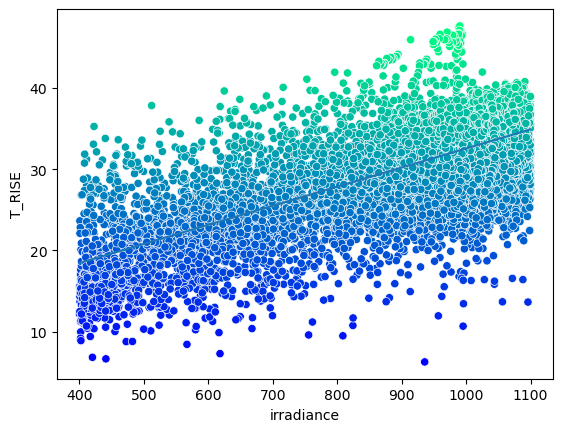

In [586]:
# Visualizing the dataset with the Regression line
axes = sns.scatterplot(data=combined_df, x='irradiance', y='T_RISE', hue='T_RISE', palette='winter', legend=False)
#axes.set_ylim(400,1000)
x = np.array([min(combined_df.irradiance.values), max(combined_df.irradiance.values)])
y = predict(x)
line = plt.plot(x,y)

# Multiple Linear Regression

In [501]:
target = "module_temperature"
feature_names = ['irradiance', 'wind_speed', 'wind_direction', 'ambient_temperature']

In [502]:
display(combined_df[feature_names].shape)
display(combined_df[target].shape)

(21498, 4)

(21498,)

In [503]:
sample_df = combined_df.sample(frac=0.1, random_state=17)

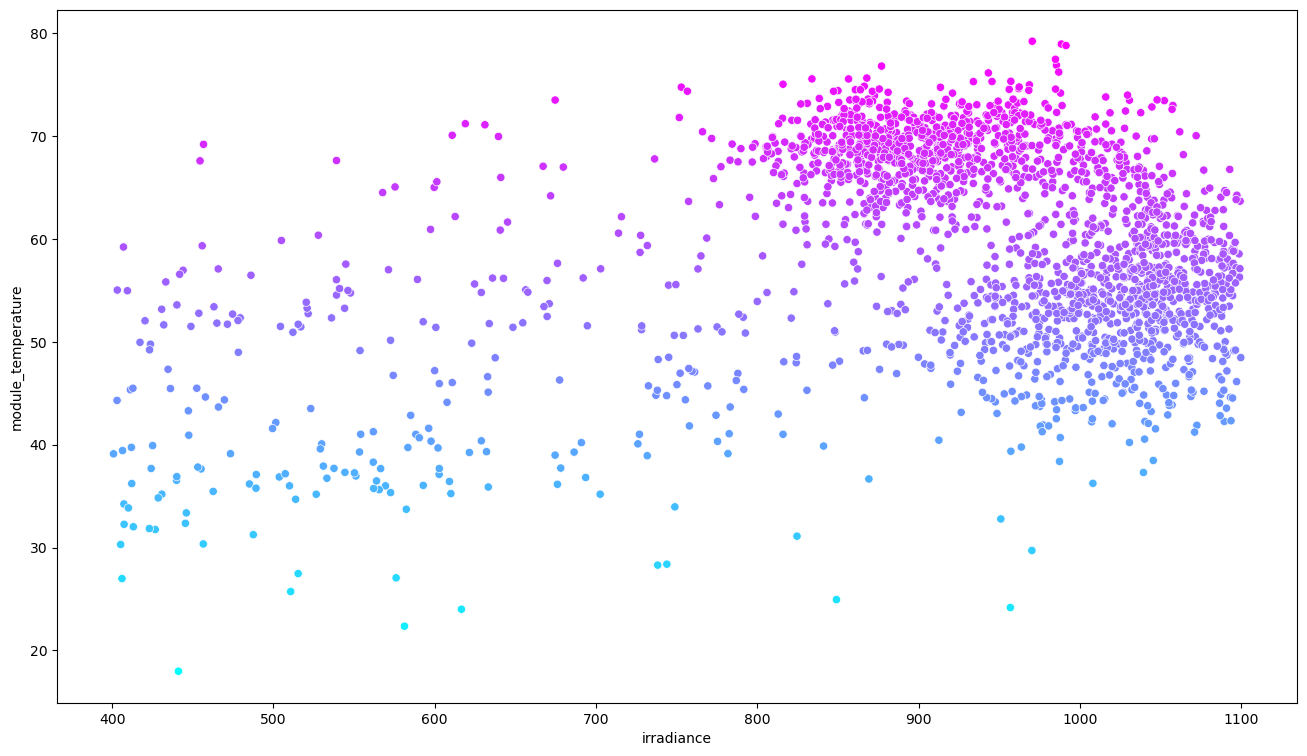

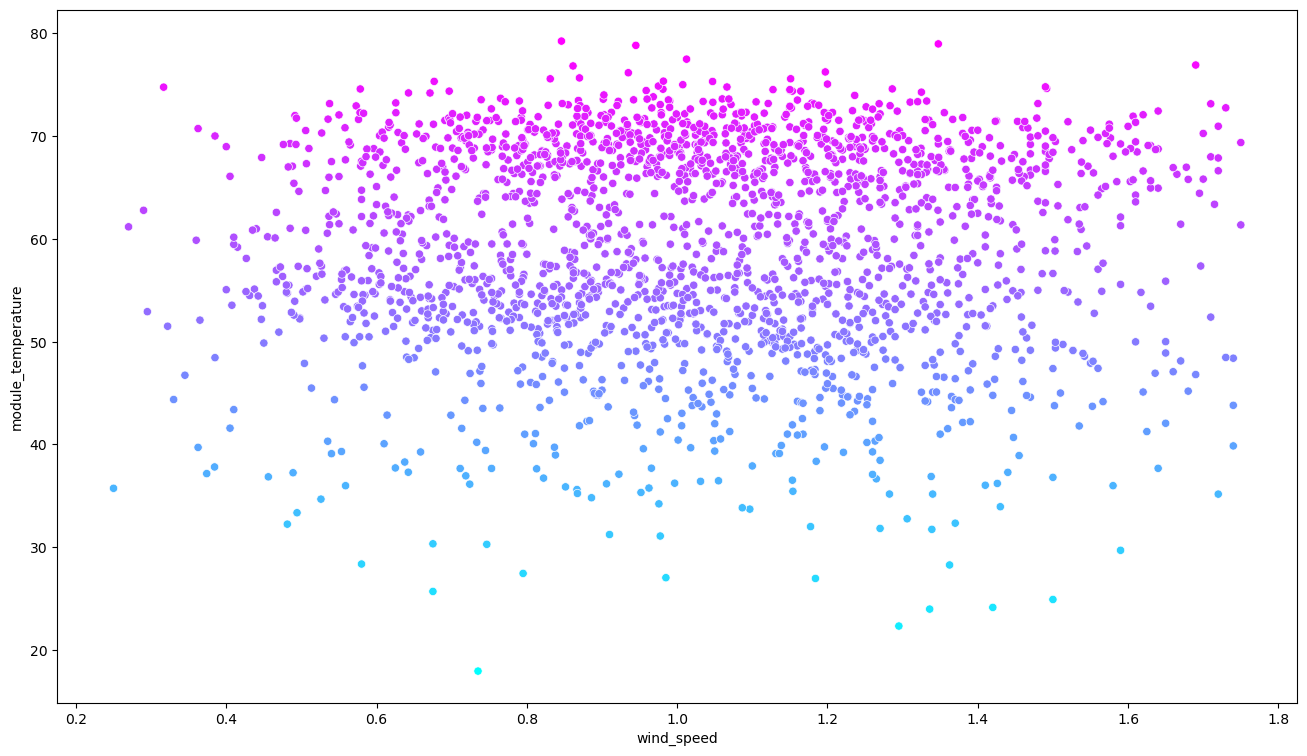

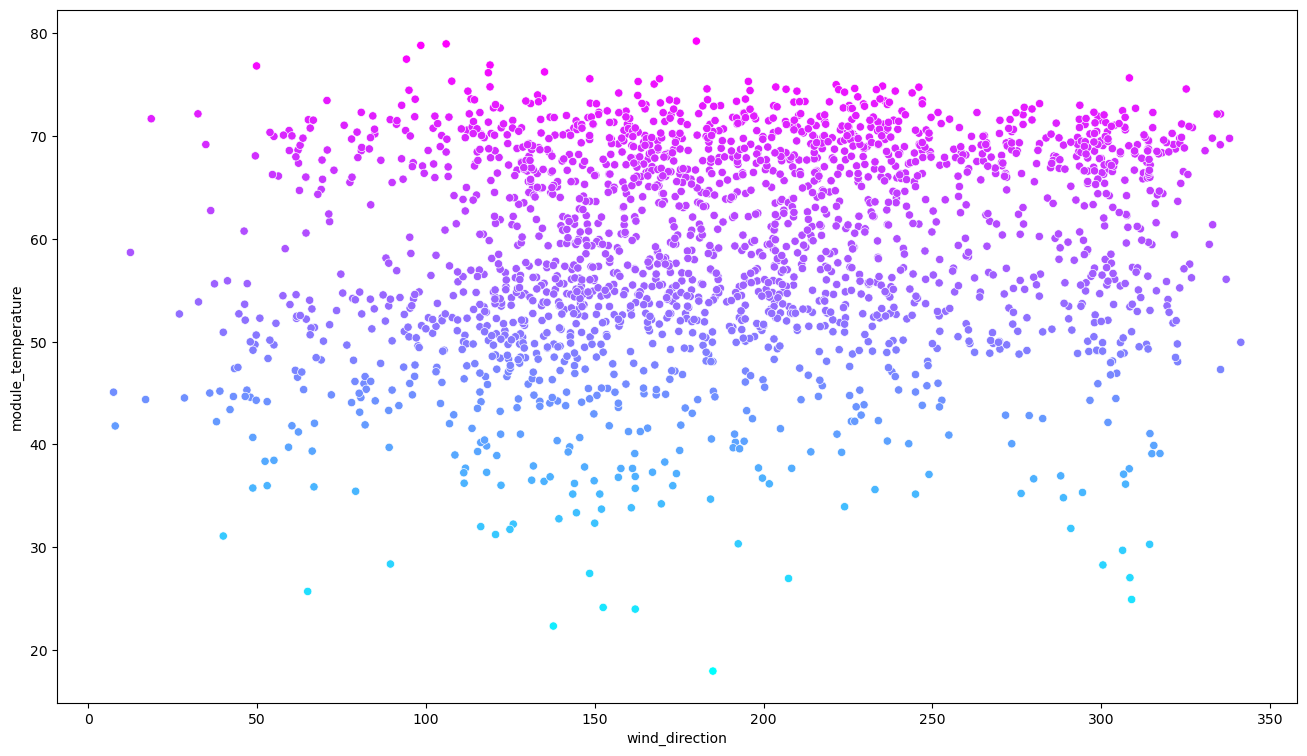

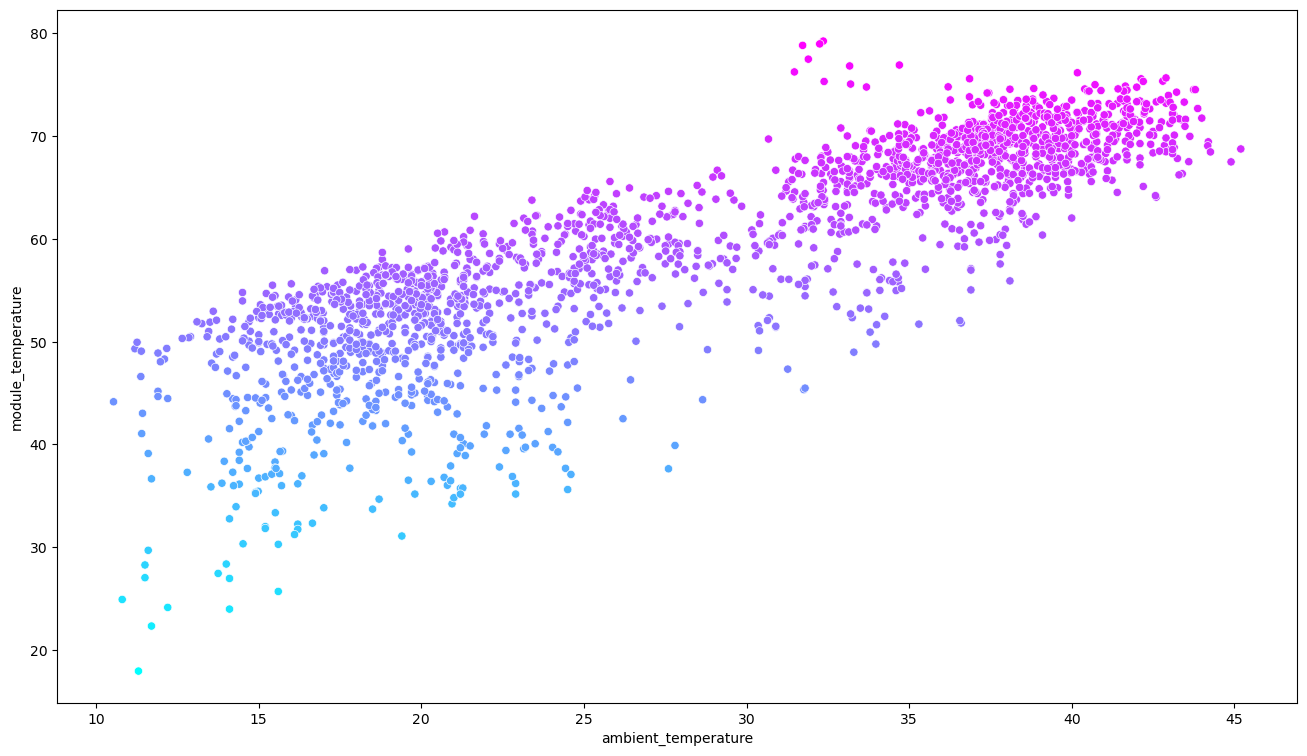

In [504]:
for feature in feature_names:
    plt.figure(figsize=(16,9))
    sns.scatterplot(data=sample_df, x=feature, y=target, hue=target, palette='cool', legend=False)

In [505]:
sample_df[feature_names].corr()

,irradiance,wind_speed,wind_direction,ambient_temperature
irradiance,1.000000,0.053927,-0.044578,-0.180135
wind_speed,0.053927,1.000000,0.051648,0.132416
wind_direction,-0.044578,0.051648,1.000000,0.193145
ambient_temperature,-0.180135,0.132416,0.193145,1.000000


In [506]:
X_train, X_test, y_train, y_test = train_test_split(combined_df[feature_names], combined_df[target], random_state=11)
display(X_train.shape)
display(X_test.shape)


(16123, 4)

(5375, 4)

In [507]:
linear_regression = LinearRegression()
linear_regression.fit(X=X_train, y=y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(normalize=False)

In [508]:
# Regression coefficients
for i, name in enumerate(feature_names):
    print(f'{name:>10}: {linear_regression.coef_[i]}')
linear_regression.intercept_

irradiance: 0.0242339896798721
wind_speed: -3.9864134702851493
wind_direction: 0.0022960230253254834
ambient_temperature: 1.020292501107502


11.442995774265427

In [509]:
# Testing the model
predicted = linear_regression.predict(X_test)
expected = y_test

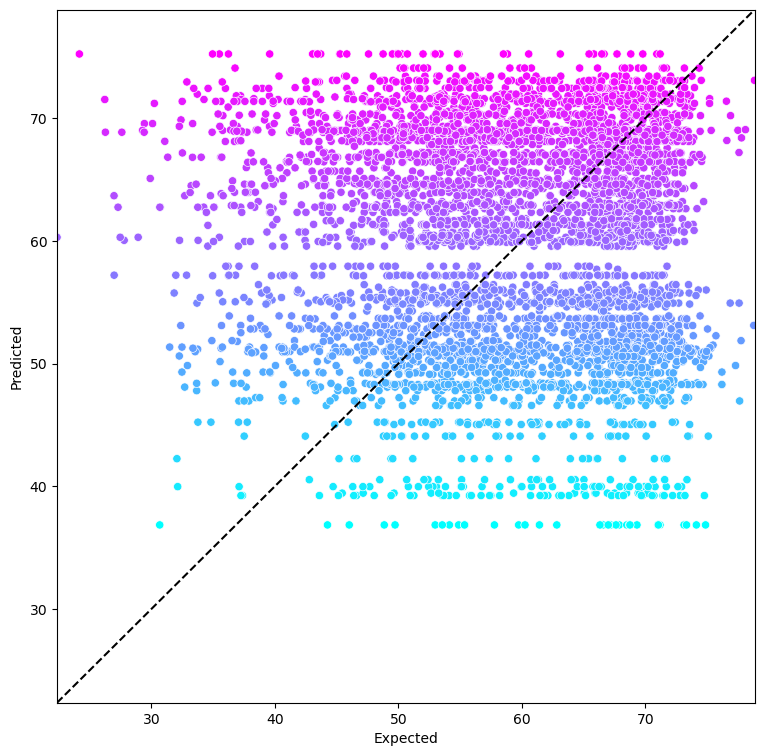

In [514]:
# Visualizing the Expected vs. Predicted
df = pd.DataFrame()
df['Expected'] = pd.Series(expected)
df['Predicted'] = pd.Series(predicted)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=df, x= 'Expected', y='Predicted', hue='Predicted', palette='cool', legend=False)

# Set the x- and y-axes limits to use the same scale along both axes
start = min(expected.min(), predicted.min())
end = max(expected.max(), predicted.max())
axes.set_xlim(start, end)
axes.set_ylim(start, end)

line = plt.plot([start, end], [start, end], 'k--')

In [431]:
# Regression Model Metrics
display(metrics.r2_score(expected, predicted))
display(metrics.mean_squared_error(expected, predicted))

0.8752383939045496

12.003087428897105

# Choosing the best Model

In [435]:
# Let's run several regression estimators
estimators = {
    'LinearRegression': linear_regression,
    'ElasticNet': ElasticNet(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

In [438]:
# We run estimators using k-fold cross-validation with a KFold object and the cross_val_score function
for estimator_name, estimator_object in estimators.items():
    kfold = KFold(n_splits=10, random_state=11, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, X=combined_df[feature_names], y=combined_df[target], cv=kfold, scoring='r2')
    print(f'{estimator_name:>16}: mean of r2 scores = {scores.mean():.3f}')

LinearRegression: mean of r2 scores = 0.870
      ElasticNet: mean of r2 scores = 0.856
           Lasso: mean of r2 scores = 0.856
           Ridge: mean of r2 scores = 0.870


# Using Deep Learning

In [515]:
# Import the necessary libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 

In [516]:
# Split into training and testing windows
X_train, X_test, y_train, y_test = train_test_split(combined_df[feature_names], combined_df[target], random_state=11)

In [532]:
# Create model
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=4))
model.add(Dense(16, activation="relu"))
model.add(Dense(4, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])

# Calculate predictions
PredTestSet = model.predict(X_train)
PredValSet = model.predict(X_test)

# Save predictions
np.savetxt("trainresults.csv", PredTestSet, delimiter=",")

Epoch 1/10000000


C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


162/162 - 1s - loss: 3607.0208 - val_loss: 3588.8718 - 718ms/epoch - 4ms/step
Epoch 2/10000000
162/162 - 0s - loss: 3587.9119 - val_loss: 3569.8188 - 247ms/epoch - 2ms/step
Epoch 3/10000000
162/162 - 0s - loss: 3568.8750 - val_loss: 3550.8293 - 251ms/epoch - 2ms/step
Epoch 4/10000000
162/162 - 0s - loss: 3549.9326 - val_loss: 3531.9568 - 256ms/epoch - 2ms/step
Epoch 5/10000000
162/162 - 0s - loss: 3531.0837 - val_loss: 3513.1599 - 255ms/epoch - 2ms/step
Epoch 6/10000000
162/162 - 0s - loss: 3512.3162 - val_loss: 3494.4558 - 256ms/epoch - 2ms/step
Epoch 7/10000000
162/162 - 0s - loss: 3493.6326 - val_loss: 3475.8289 - 255ms/epoch - 2ms/step
Epoch 8/10000000
162/162 - 0s - loss: 3475.0308 - val_loss: 3457.2803 - 252ms/epoch - 2ms/step
Epoch 9/10000000
162/162 - 0s - loss: 3456.5095 - val_loss: 3438.8181 - 248ms/epoch - 2ms/step
Epoch 10/10000000
162/162 - 0s - loss: 3438.0791 - val_loss: 3420.4414 - 276ms/epoch - 2ms/step
Epoch 11/10000000
162/162 - 0s - loss: 3419.7224 - val_loss: 3402.

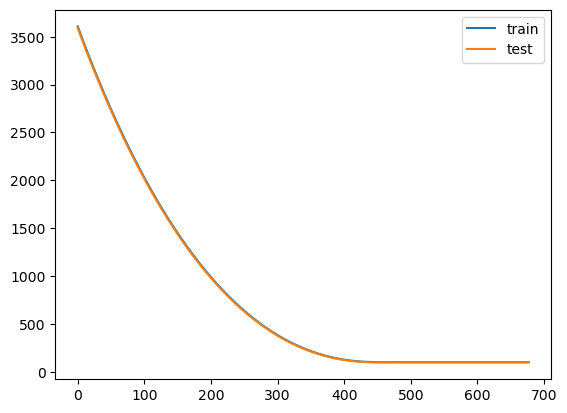

In [533]:
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Training Set R-Square= -3.9360762094098334e-07


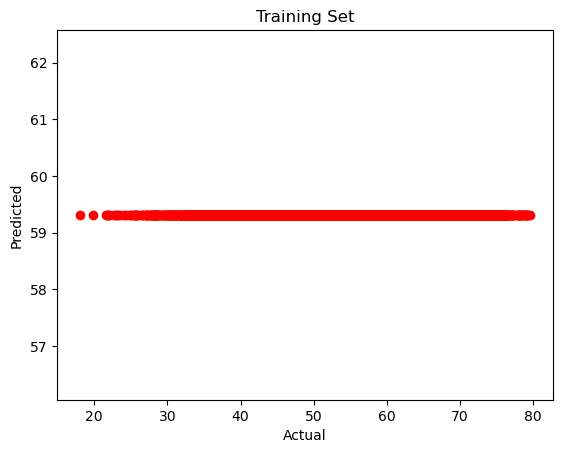

In [534]:
# Plot actual vs prediction for training set
plt.plot(y_train,PredTestSet,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = metrics.r2_score(y_train,PredTestSet)
print("Training Set R-Square=", TestR2Value)

Test Set R-Square= -2.6741692946030682e-05


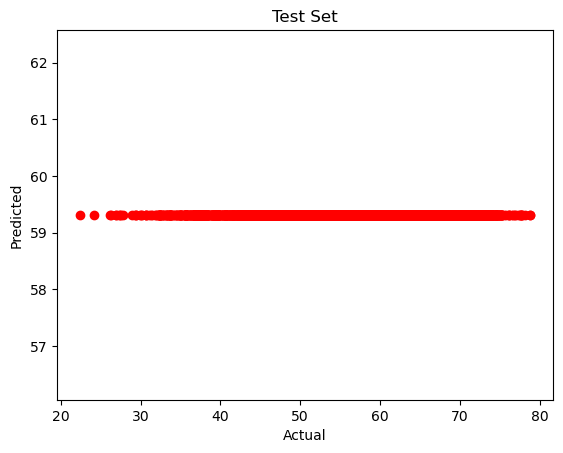

In [535]:
# Plot actual vs prediction for validation set
plt.plot(y_test,PredValSet,'ro')
plt.title('Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for validation set
ValR2Value = metrics.r2_score(y_test,PredValSet)
print("Test Set R-Square=",ValR2Value)

In [536]:
hidden_layer_weights, hidden_layer_biases = model.layers[0].get_weights()
output_layer_weights, output_layer_biases = model.layers[-1].get_weights()
display(output_layer_weights)
display(output_layer_biases)

array([[-0.3484872 ],
       [-0.61416954],
       [ 0.7182988 ],
       [-0.89905685]], dtype=float32)

array([59.311], dtype=float32)